<a href="https://colab.research.google.com/github/allyssonallan/PDL_medicine/blob/main/PDL_for_medicina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse tutorial é baseado no artigo **A guide on Deep Learning for Genomic Prediction** (*Genes, 2019*) de M Perez-Enciso & ML Zingaretti. [Leia o artigo](https://www.mdpi.com/2073-4425/10/7/553).


In [ ]:
## instalacao
#python3.7 -m pip install -r requirements.txt
### ou
!pip install -r requirements.txt


In [ ]:

# modulos principais
import sys
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

# keras itens
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D, LSTM #CNNs
from tensorflow.keras.activations import relu, elu, linear, softmax
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.losses import mean_squared_error, categorical_crossentropy, logcosh
from tensorflow.keras.utils import to_categorical

# talos items (hiperparametros)
import wrangle as wr
import talos


AttributeError: ignored

(479, 1279) (479,)
(120, 1279) (120,)
       min max mean sd
Train: -2.41866172921982 3.27892080508434 0.022364141963760485 1.005162588158939
Test: -2.22424623595239 1.8136703909295402 -0.08927020000534379 0.9781475868971037


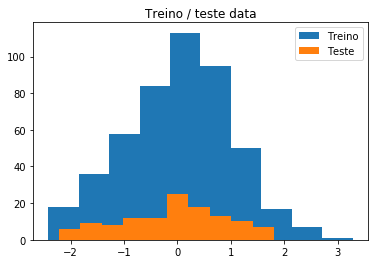

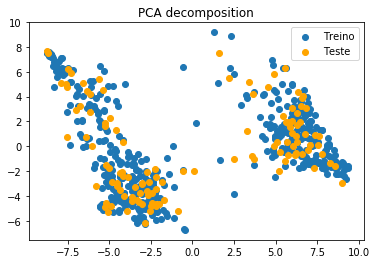

In [ ]:
X = pd.read_csv('nivel_ca.X', header=None, sep='\s+')
Y = pd.read_csv('genotype.Y', header=None, sep='\s+')

itrait=0
X_train, X_test, y_train, y_test = train_test_split(X, Y[itrait], test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

print('       min max mean sd')
print('Train:', y_train.min(), y_train.max(), y_train.mean(), np.sqrt(y_train.var()))
print('Test:', y_test.min(), y_test.max(), y_test.mean(), np.sqrt(y_test.var()))

plt.title('Treino / teste data')
plt.hist(y_train, label='Treino')
plt.hist(y_test, label='Teste')
plt.legend(loc='best')
plt.show()

X = np.concatenate((X_train, X_test))
pca = PCA(n_components=2)
p = pca.fit(X).fit_transform(X)
Ntrain=X_train.shape[0]
plt.title('PCA decomposition')
plt.scatter(p[0:Ntrain,0], p[0:Ntrain,1], label='Treino')
plt.scatter(p[Ntrain:,0], p[Ntrain:,1], label='Teste', color='orange')
plt.legend(loc='best')
plt.show()


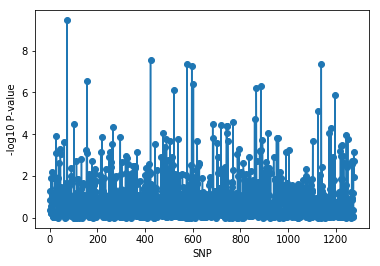

In [ ]:

pvals = []
for i in range(X_train.shape[1]):
    b, intercept, r_value, p_value, std_err = stats.linregress(X_train[i], y_train)
    pvals.append(-np.log10(p_value))
pvals = np.array(pvals)


plt.ylabel('-log10 P-value')
plt.xlabel('SNP')
plt.plot(pvals, marker='o')
plt.show()


N_best = 100
snp_list = pvals.argsort()[-N_best:]


min_P_value = 2 # P = 0.01
snp_list = np.nonzero(pvals>min_P_value)


X_train = X_train[X_train.columns[snp_list]]
X_test = X_test[X_test.columns[snp_list]]



MSE em predicao = tf.Tensor(0.7588203815758684, shape=(), dtype=float64)

Corr obs vs pred = 0.4615168526742147


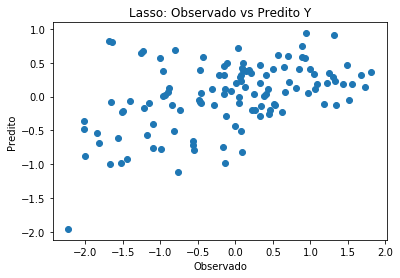

In [ ]:

lasso = linear_model.Lasso(alpha=0.01)
lasso.fit(X_train, y_train)
y_hat = lasso.predict(X_test)


mse = mean_squared_error(y_test, y_hat)
print('\nMSE em predicao =',mse)


corr = np.corrcoef(y_test,y_hat)[0,1]
print('\nCorr obs vs pred =',corr)


plt.title('Lasso: Observado vs Predito Y')
plt.ylabel('Predito')
plt.xlabel('Observado')
plt.scatter(y_test, y_hat, marker='o')
plt.show()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                9792      
_________________________________________________________________
activation_2 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
_________________________________________________________________
Train on 479 samples
Epoch 1/100
479/479 [==============================] - 0s 466us/sample - loss: 1.2338
Epoch 2/1

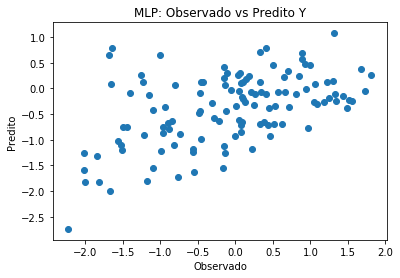

In [ ]:
#número de snps nos dados
nSNP=X_train.shape[1]

#modo de instanciamento
model = Sequential()

#camada 1
model.add(Dense(64, input_dim=nSNP))
model.add(Activation('relu'))

#camada 2
model.add(Dense(32))
model.add(Activation('softplus'))

#camada output
model.add(Dense(1))

# Model Compiling (https://keras.io/models/sequential/)
# compile(optimizer, loss=None, metrics=None, loss_weights=None, sample_weight_mode=None, weighted_metrics=None, target_tensors=None)
# Stochastic Gradient Descent (‘sgd’) como algoritmo de otimização
#Erro médio quadrático como perda
model.compile(loss='mean_squared_error', optimizer='sgd')

# mostrar as propriedades
model.summary()

# treinar
# fit(x=None, y=None, batch_size=None, epochs=1, verbose=1, callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_freq=1)
model.fit(X_train, y_train, epochs=100)

# validação: obter os valores de predição
y_hat = model.predict(X_test, batch_size=128)

mse_prediction = model.evaluate(X_test, y_test, batch_size=128)
print('\nMSE em predicao =',mse_prediction)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observado vs Predito Y')
plt.ylabel('Predito')
plt.xlabel('Observado')
plt.scatter(y_test, y_hat, marker='o')
plt.show()



In [ ]:
#controlar o overfitting

del model

model = Sequential()

# Add l1 & l2 regularization in first layer
model.add(Dense(64, input_dim=nSNP,
                kernel_regularizer=regularizers.l2(0.01),
                activity_regularizer=regularizers.l1(0.01)))
model.add(Activation('relu'))
# Add second layer
model.add(Dense(32))
model.add(Activation('softplus'))
## Adding dropout to second layer
model.add(Dropout(0.2))
# Last, output layer
model.add(Dense(1))

# Model Compiling (https://keras.io/models/sequential/)
model.compile(loss='mean_squared_error', optimizer='sgd')

# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)
nEpochs=100

# Early stopping
early_stopper = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.01)
model.fit(X_train0, y_train0, epochs=nEpochs, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopper])

# cross-validation
mse_prediction = model.evaluate(X_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

## In this case neither l1 nor l2 regularization helps

Train on 431 samples, validate on 48 samples
Epoch 1/100
431/431 [==============================] - 0s 871us/sample - loss: 2.8243 - val_loss: 2.5874
Epoch 2/100
431/431 [==============================] - 0s 77us/sample - loss: 2.4699 - val_loss: 2.4881
Epoch 3/100
431/431 [==============================] - 0s 68us/sample - loss: 2.4137 - val_loss: 2.4490
Epoch 4/100
431/431 [==============================] - 0s 67us/sample - loss: 2.2666 - val_loss: 2.3316
Epoch 5/100
431/431 [==============================] - 0s 65us/sample - loss: 2.2717 - val_loss: 2.2872
Epoch 6/100
431/431 [==============================] - 0s 69us/sample - loss: 2.1941 - val_loss: 2.2785
Epoch 7/100
431/431 [==============================] - 0s 64us/sample - loss: 2.1624 - val_loss: 2.2097
Epoch 8/100
431/431 [==============================] - 0s 79us/sample - loss: 2.1043 - val_loss: 2.2070
Epoch 9/100
431/431 [==============================] - 0s 85us/sample - loss: 2.0848 - val_loss: 2.2126
Epoch 10/100
431/4

In [ ]:


from tensorflow.keras import backend as K

def acc_pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)


In [ ]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: Simple example
# https://autonomio.github.io/docs_talos/
# 1. Hyperparameter ranges and Model definition

# model definition
def baby_model(x, y, x_val, y_val, params):
    # replace the hyperparameter inputs with references to params dictionary
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x.shape[1],
                activation=params['activation']))
    #last neuron
    model.add(Dense(1, activation=None))
    model.compile(loss=mean_squared_error, optimizer='sgd', metrics=[acc_pearson_r])

    # make sure history object is returned by model.fit()
    out = model.fit(x, y,
                    epochs=50,
                    validation_data=[x_val, y_val],
                    batch_size=params['batch_size'],
                    verbose=0,callbacks=[live()])

    # modify the output model
    return out, model

# dictionary with hyperparameters and range values allowed
p = {
    'first_neuron': [12, 48],
    'activation': [relu, elu],
    'batch_size': [10, 30]
}


In [ ]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: Simple example
# 2. Search, run this grid should take between 1-2 minutes


# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_train0=np.asarray(X_train0)
X_val=np.asarray(X_val)
y_train0=np.asarray(y_train0)
y_val=np.asarray(y_val)

# COOL! this shows real time plots
t_Init = ta.Scan(x=X_train0,
                 y=y_train0,
                 x_val=X_val,
                 y_val=y_val,
                 model=baby_model,
                 params=p,
                 grid_downsample=None,   # grid search
                 dataset_name='baby_model',
                 print_params=True)

NameError: ignored

  round_epochs            val_loss  val_acc_pearson_r      loss  \
0           50  0.5657099410891533           0.526767  0.416398   
1           50  0.4832996961971124           0.533134  0.401398   
2           50  0.5437336973845959           0.528810  0.556255   
3           50  0.5385651886463165           0.457365  0.498343   
4           50  0.5820434391498566           0.408295  0.481455   
5           50  0.5022439491003752           0.541126  0.261090   
6           50  0.5909712165594101           0.496790  0.558527   
7           50  0.5774653665721416           0.507399  0.567783   

        acc_pearson_r first_neuron                         activation  \
0  0.7780445284467286           48  <function relu at 0x7f553796da60>   
1                 nan           12  <function relu at 0x7f553796da60>   
2  0.6865397805127633           12  <function relu at 0x7f553796da60>   
3                 nan           48   <function elu at 0x7f553796d730>   
4                 nan          

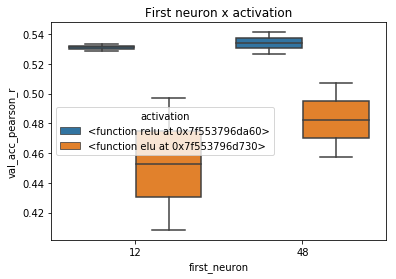

In [ ]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: Simple example
# 3. Inspect results
Data=pd.DataFrame(t_Init.data)
Data["loss"] = pd.to_numeric(Data["loss"])
Data["val_acc_pearson_r"] = pd.to_numeric(Data["val_acc_pearson_r"])
print(Data)

# Minimum loss set
i=Data['val_acc_pearson_r'].argmax()
print('\nBest prediction combination:')
print(Data[i:(i+1)],'\n')

# Visualize some parameters combinations
x = sns.boxplot(y="val_acc_pearson_r",x="first_neuron",hue="activation",data=Data).set_title('First neuron x activation')

Hyperparameter tunning: 'the real world model'. Talos uses a dictionary for keras hyperparameter optimization. You ha ve to declare the hyperparameters and their boundaries in a python dictionary.
Warning! Keras optimizer, losses, activation, initializer need to be loaded!
Note that talos Scan includes an argument called grid_downsampling, which allows a random search. Just to illustrate how to use talos, we've chosen 0.01

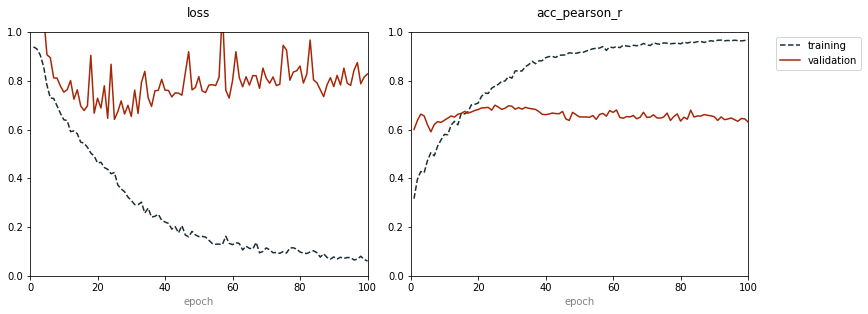

100%|██████████| 23/23 [14:17<00:00, 37.81s/it]


In [ ]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: more complex example
# We do a random search here (by downsampling among all possible grid values)

# model definition
def grown_model(x, y, x_val, y_val, params):
    # next we can build the model exactly like we would normally do it
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_dim=x.shape[1],
                    activation=params['activation'],
                    kernel_initializer=params['kernel_initializer']))

    model.add(Dropout(params['dropout']))

    # if we want to also test for number of layers and shapes, that's possible
    hidden_layers(model, params, 1)

    # then we finish again with completely standard Keras way
    model.add(Dense(1, activation=params['last_activation'],
                    kernel_initializer='normal'))

    model.compile(loss=params['losses'],
        optimizer=params['optimizer'](lr=lr_normalizer(params['lr'],params['optimizer'])),
            metrics=[acc_pearson_r])


    out = model.fit(x, y, validation_data=[x_val, y_val], verbose=0,batch_size=params['batch_size'],
                        epochs=params['epochs'],callbacks=[live()])

    # finally we have to make sure that history object and model are returned
    return out, model

# hyperparameters
p = {'first_neuron':[32,64],
     'lr':[0.2,0.5],
     'batch_size': [30,50],
     'hidden_layers':[1,2,3,4],
     'epochs': [100],
     'dropout': [0, 0.01, 0.1, 0.5],
     'optimizer': [adam,sgd,Nadam],
     'losses': [mean_squared_error],
     'activation':[relu, elu,linear],
     'last_activation': [None],
     'kernel_initializer':["uniform","normal"]}

# Split the train set into proper train & validation
X_train0, X_val, y_train0, y_val = train_test_split(X_train, y_train, test_size=0.1)
X_train0=np.asarray(X_train0)
X_val=np.asarray(X_val)
y_train0=np.asarray(y_train0)
y_val=np.asarray(y_val)

# Example with multiclass target
# grid_downsample number of combinations to be checked 10% in this example
tcomp = ta.Scan(x=X_train0,
                y=y_train0,
                x_val=X_val,
                y_val=y_val,
                model=grown_model,
                params=p,
                grid_downsample=0.01,
                print_params=True,
                dataset_name='grown_model')


In [ ]:
# HYPERPARAMETER OPTIMIZATION USING TALOS: more complex example
# Some plotting
Data=pd.DataFrame(tcomp.data)
Data["val_loss"] = pd.to_numeric(Data["val_loss"])
Data["acc_pearson_r"] = pd.to_numeric(Data["acc_pearson_r"])
Data["val_acc_pearson_r"] = pd.to_numeric(Data["val_acc_pearson_r"])
#print Data
#print(Data)
#write Data
Data.to_csv("mlp_real_world.csv",index=False)



Best loss combination:
  round_epochs  val_loss  val_acc_pearson_r                 loss  \
8          100  0.591251           0.729234  0.09926358582732848   

   acc_pearson_r first_neuron   lr batch_size hidden_layers epochs dropout  \
8       0.952372           32  0.5         30             3    100       0   

                          optimizer  \
8  <class 'keras.optimizers.Nadam'>   

                                            losses  \
8  <function mean_squared_error at 0x7f55379c1620>   

                          activation last_activation kernel_initializer  
8  <function relu at 0x7f553796da60>            None             normal   



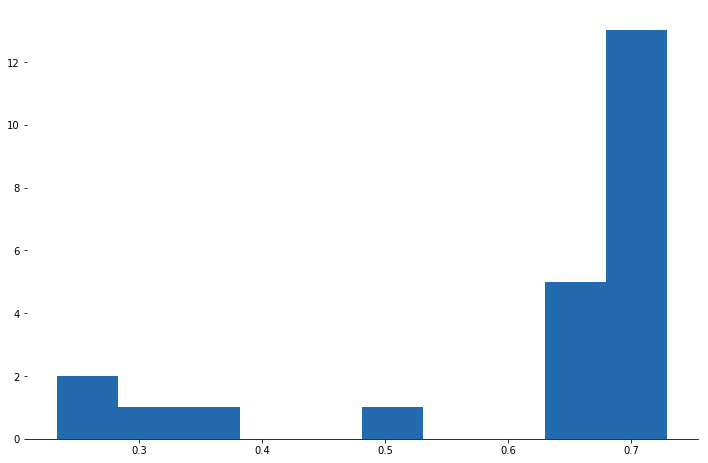

In [ ]:
# Maximum correlation
i=Data['val_acc_pearson_r'].argmax()
print('\nBest loss combination:')
print(Data[i:(i+1)],'\n')
# talos have a function called reporting, which has implemented some plots
# reporting to see the best model, draw an histogram
r = ta.Reporting('mlp_real_world.csv')
r.plot_hist('val_acc_pearson_r')

0.7292338609695435


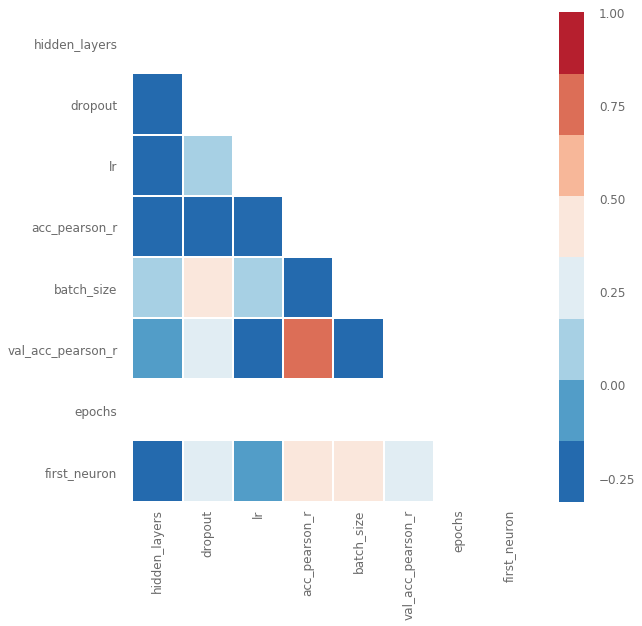

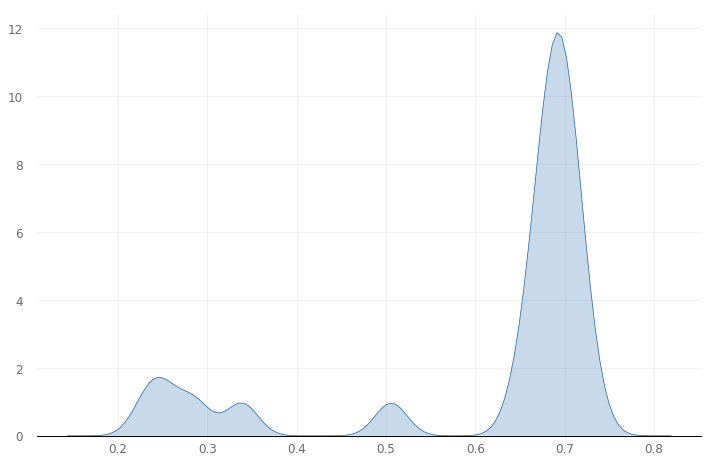

In [ ]:
print(r.high('val_acc_pearson_r'))
# we can check the correlation between val accuracy and other parameters into the model
r.plot_corr('val_acc_pearson_r')
# we can see the distribution of the val_acc parameter chosen
r.plot_kde('val_acc_pearson_r')


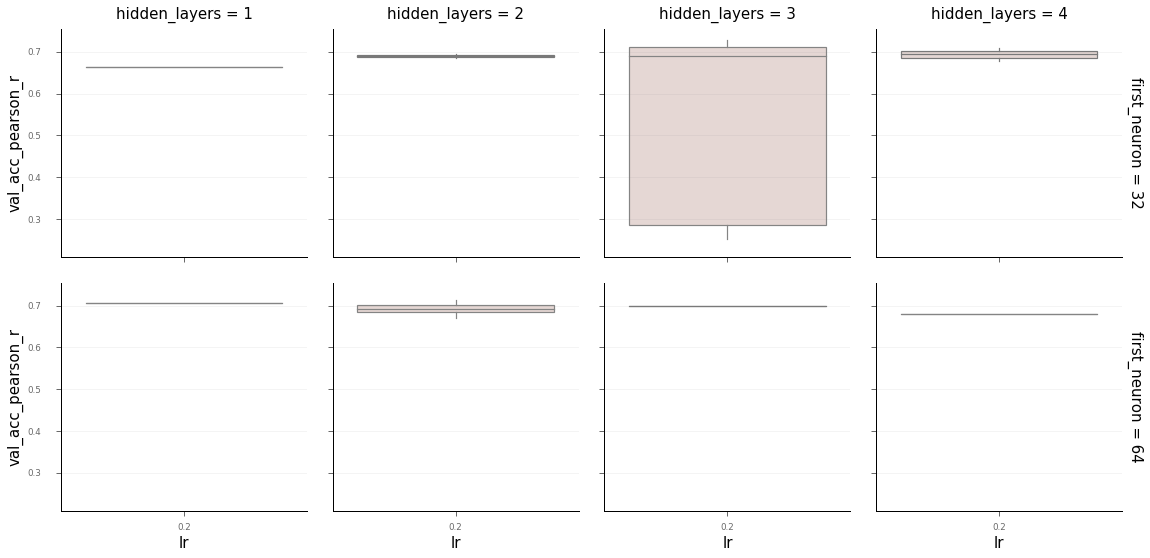

In [ ]:
import seaborn as sns
# You also can use seaborn to check other combination of parameters
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
g = sns.FacetGrid(tcomp.data, col="hidden_layers",row="first_neuron", margin_titles=True,height=4)
g.map(sns.boxplot,"lr","val_acc_pearson_r", palette=sns.cubehelix_palette(8),saturation=.5);

In [ ]:
# Model evaluation
# talos has a function to evaluate the model from Scan object

from talos import Evaluate

# create the evaluate object
e = Evaluate(tcomp)

# perform the evaluation
e.evaluate(X_val, y_val,metric="val_acc_pearson_r" ,mode="regression")
# model regression uses the mean absolute error by default. Custom metrics are not allowing in evaluate
#Warning: note we use the same data than in scan validation, however, it should be used a fully different
# dataset (the validation set)!

[0.4606610017592659,
 0.6346189441220046,
 0.7772777641816996,
 0.9285761702344065,
 0.9188610468308843]

Finally, use Deploy() to save and transfer the results of your "star" model

In [ ]:
from talos import Deploy

Deploy(tcomp, 'the_real_word_experiment',metric='val_acc_pearson_r',asc=False)


Deploy package the_real_word_experiment have been saved.


N / class
Test  [92, 325, 62]
Train  [28, 82, 9]
All  [120, 407, 71]
120/120 [==============================] - 0s 303us/step

MSE in prediction = 1.9539129734039307

Probabilities matrix
 [[4.98802185e-01 5.00344932e-01 8.50225741e-04 2.62647745e-06]
 [1.26840040e-01 7.08234668e-01 1.64918616e-01 6.66051301e-06]
 [5.18083246e-03 8.04375231e-01 1.90427586e-01 1.63530913e-05]
 [4.72085958e-04 1.00223355e-01 8.99295986e-01 8.53616348e-06]]


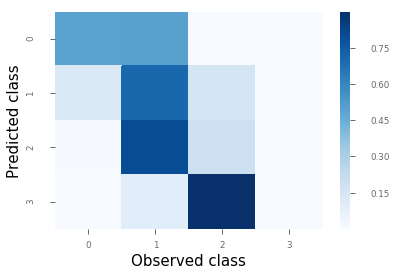

In [ ]:
# MLP example with multiclass target

# Let us round class vector and make a few classes, all positive numbers
# just a trick to convert to classes
yi_train=[int(round(x-np.min(y_train))/2) for x in y_train]
yi_test=[int(round(x-np.min(y_test))/2) for x in y_test]

# N obs / clas; this may result in some very rare classes so consider merging
print('N / class')
print('Test ',[yi_train.count(i) for i in range(max(yi_train+yi_test))])
print('Train ',[yi_test.count(i) for i in range(max(yi_train+yi_test))])
print('All ',[(yi_test+yi_train).count(i) for i in range(max(yi_train+yi_test))])
# WARNING: make sure all clases in test are in train!!

# convert to classes, i need to make all classes equivalent
n_train=len(yi_train)
itemp = to_categorical(yi_train+yi_test)
i_train = itemp[:n_train,:]
i_test = itemp[n_train:,:]

# no. of SNPs in data
nSNP=X_train.shape[1]
nClasses=i_train.shape[1]

# Instantiate
model = Sequential()

# Add first layer
model.add(Dense(64, input_dim=nSNP))
model.add(Activation('relu'))
# Add second layer
model.add(Dense(32))
model.add(Activation('softplus'))
# Last, output layer
model.add(Dense(nClasses, activation='softmax'))

# Model Compiling
model.compile(loss='categorical_crossentropy', optimizer='adam')

# training
model.fit(X_train, i_train, epochs=100, verbose=0)

# cross-validation: get predicted target values
i_hat = model.predict(X_test, batch_size=128)

mse_prediction = model.evaluate(X_test, i_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# do a heatplot, obs vs expected class distribution
# collect all results by class
# compute average prediction by class
heat = np.zeros([nClasses,nClasses])
for i in range(nClasses):
    iclass = np.nonzero(i_test[:,i]>0) # samples of i-th class
    for j in range(nClasses):
        heat[i,j] = np.mean(i_hat[iclass,j])

# plot observed vs. predicted targets
print('\nProbabilities matrix\n',heat)
plot = sns.heatmap(heat, cmap="Blues")
plot.set(xlabel='Observed class', ylabel='Predicted class')
plt.show()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 46, 32)            128       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 23, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 736)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                47168     
_________________________________________________________________
activation_3 (Activation)    (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080      
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0         
__________

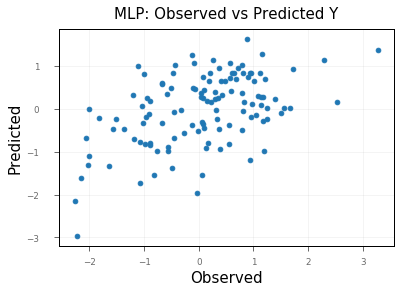

In [ ]:
#--> CNN example

nSNP=X_train.shape[1]
nStride=3  # stride between convolutions
nFilter=32 # no. of convolutions

# Instantiate
model_cnn = Sequential()

#WARNING!!! I need this to match dimensions
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
X2_train = np.expand_dims(X_train, axis=2)
X2_test = np.expand_dims(X_test, axis=2)

# add convolutional layer
model_cnn.add(Conv1D(nFilter, kernel_size=3, strides=nStride, input_shape=(nSNP,1)))
# add pooling layer: takes maximum of two consecutive values
model_cnn.add(MaxPooling1D(pool_size=2))
# Solutions above are linearized to accommodate a standard layer
model_cnn.add(Flatten())
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(32))
model_cnn.add(Activation('softplus'))
model_cnn.add(Dense(1))

# Model Compiling (https://keras.io/models/sequential/)
model_cnn.compile(loss='mean_squared_error', optimizer='sgd')

# list some properties
model_cnn.summary()

# training
model_cnn.fit(X2_train, y_train, epochs=200, verbose=0)

# cross-validation
mse_prediction = model_cnn.evaluate(X2_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# get predicted target values
y_hat = model_cnn.predict(X2_test, batch_size=128)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

In [ ]:
print(X_train.shape)

(479, 140)


In [ ]:
#--> RNN example

nSNP=X_train.shape[1]

#-->data shape
X2_train = np.expand_dims(X_train, axis=2)
X2_test = np.expand_dims(X_test, axis=2)

# Instantiate
model_cnn = Sequential()

# Instantiate
model = Sequential()
model.add(LSTM(32,return_sequences=True,input_shape=(None,1), activation="tanh"))
model.add(Dropout(0.1))
model.add(LSTM(64, return_sequences=True, activation="tanh"))
model.add(Dropout(0.1))
model.add(LSTM(64, activation="tanh"))
model.add(Dropout(0.1))
model.add(Dense(units=1))
model.add(Activation("tanh"))
model.compile(optimizer="adam",loss=mean_squared_error, metrics=['mae'])
model.summary()

model.fit(X2_train, y_train, epochs=200, verbose=0)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          4352      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 64)          24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
__________

In [ ]:
# cross-validation
mse_prediction = model.evaluate(X2_test, y_test, batch_size=128)
print('\nMSE in prediction =',mse_prediction)

# get predicted target values
y_hat = model.predict(X2_test, batch_size=128)

# correlation btw predicted and observed
corr = np.corrcoef(y_test,y_hat[:,0])[0,1]
print('\nCorr obs vs pred =',corr)

# plot observed vs. predicted targets
plt.title('MLP: Observed vs Predicted Y')
plt.ylabel('Predicted')
plt.xlabel('Observed')
plt.scatter(y_test, y_hat, marker='o')
plt.show()

In [ ]:
# save and reuse model
from keras.models import load_model

# creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# deletes the existing model
del model

# loads a compiled model, identical to the previous one
model = load_model('my_model.h5')